In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
from geopy.geocoders import Nominatim
from functools import lru_cache
from wordcloud import WordCloud, STOPWORDS
import arabic_reshaper
from bidi.algorithm import get_display
import re
import warnings

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_style('white')
pd.set_option('display.max_column', 100)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
data = pd.read_csv('../dataset/geocoded_data.csv')
data.head()

HouseType   Price  Size  Bedrooms  Bathrooms  Level  Furnished   
0  Apartment   35000   165         3          3      0          1  \
1  Apartment   77000   225         3          3      2          1   
2  Apartment   30000   280         4          3      1          0   
3  Apartment    1500   120         3          2      2          1   
4  Apartment  160000    14         2          3      1          1   

               Area   City  ElectricityMeter  BuiltinKitchenAppliances   
0          Madinaty  Cairo                 1                         1  \
1      Uptown Cairo  Cairo                 0                         0   
2         Nasr City  Cairo                 1                         0   
3         Nasr City  Cairo                 1                         1   
4  Katameya Heights  Cairo                 1                         0   

   WaterMeter  Elevator  Balcony  NaturalGas  Landline  Security  CentralAC   
0           1         0        1           1         0         1          1  \
1           0         0        1           0         0         1          0   
2           1         1        1           1         1         1          0   
3           1         0        1           1         0         0          1   
4           1         0        1           0         0         1          1   

   CoveredParking  PetsAllowed  PrivateGarden  MaidsRoom  Pool        Lat   
0               0            0              1          0     0  30.093319  \
1               1            1              0          1     0  30.023628   
2               0            0              0          0     0  30.052118   
3               0            0              0          0     0  30.052118   
4               0            1              0          0     0  29.995397   

        Long  
0  31.637916  
1  31.304425  
2  31.342205  
3  31.342205  
4  31.405358

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11362 entries, 0 to 11361
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   HouseType                 11362 non-null  object 
 1   Price                     11362 non-null  int64  
 2   Size                      11362 non-null  int64  
 3   Bedrooms                  11362 non-null  int64  
 4   Bathrooms                 11362 non-null  int64  
 5   Level                     11362 non-null  int64  
 6   Furnished                 11362 non-null  int64  
 7   Area                      11362 non-null  object 
 8   City                      11362 non-null  object 
 9   ElectricityMeter          11362 non-null  int64  
 10  BuiltinKitchenAppliances  11362 non-null  int64  
 11  WaterMeter                11362 non-null  int64  
 12  Elevator                  11362 non-null  int64  
 13  Balcony                   11362 non-null  int64  
 14  Natura

##### Summary statistics Suggests that there are extreme values-Outliers in our dataset

In [4]:
data.describe()

Price           Size      Bedrooms     Bathrooms         Level   
count  1.136200e+04   11362.000000  11362.000000  11362.000000  11362.000000  \
mean   2.426234e+04     193.507833      2.686059      2.087749      2.410403   
std    9.681809e+04    1475.450879      0.792601      0.858818      2.106263   
min    2.000000e+02       1.000000      1.000000      1.000000      0.000000   
25%    1.200000e+04     104.000000      2.000000      1.000000      1.000000   
50%    1.800000e+04     140.000000      3.000000      2.000000      2.000000   
75%    3.000000e+04     200.000000      3.000000      3.000000      3.000000   
max    6.800000e+06  140000.000000     10.000000      8.000000     12.000000   

          Furnished  ElectricityMeter  BuiltinKitchenAppliances    WaterMeter   
count  11362.000000       11362.00000              11362.000000  11362.000000  \
mean       0.523939           0.85786                  0.553600      0.841401   
std        0.499449           0.34921                  0.497141      0.365318   
min        0.000000           0.00000                  0.000000      0.000000   
25%        0.000000           1.00000                  0.000000      1.000000   
50%        1.000000           1.00000                  1.000000      1.000000   
75%        1.000000           1.00000                  1.000000      1.000000   
max        1.000000           1.00000                  1.000000      1.000000   

           Elevator       Balcony    NaturalGas      Landline      Security   
count  11362.000000  11362.000000  11362.000000  11362.000000  11362.000000  \
mean       0.649710      0.875462      0.757085      0.703133      0.825383   
std        0.477266      0.330209      0.428863      0.456897      0.379656   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      1.000000      1.000000      0.000000      1.000000   
50%        1.000000      1.000000      1.000000      1.000000      1.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max        2.000000      1.000000      1.000000      1.000000      1.000000   

          CentralAC  CoveredParking   PetsAllowed  PrivateGarden   
count  11362.000000    11362.000000  11362.000000   11362.000000  \
mean       0.479317        0.278824      0.283665       0.164672   
std        0.499594        0.448441      0.450796       0.370900   
min        0.000000        0.000000      0.000000       0.000000   
25%        0.000000        0.000000      0.000000       0.000000   
50%        0.000000        0.000000      0.000000       0.000000   
75%        1.000000        1.000000      1.000000       0.000000   
max        1.000000        1.000000      1.000000       1.000000   

          MaidsRoom          Pool           Lat          Long  
count  11362.000000  11362.000000  11362.000000  11362.000000  
mean       0.099366      0.082028     30.985536     22.776635  
std        0.299166      0.274419      4.099040     32.269329  
min        0.000000      0.000000      0.322599    -84.207943  
25%        0.000000      0.000000     30.043178     31.202023  
50%        0.000000      0.000000     30.063584     31.475471  
75%        0.000000      0.000000     30.093319     31.637916  
max        1.000000      1.000000     54.894418    122.589558

##### Check the missing values, dataset has no missing values.

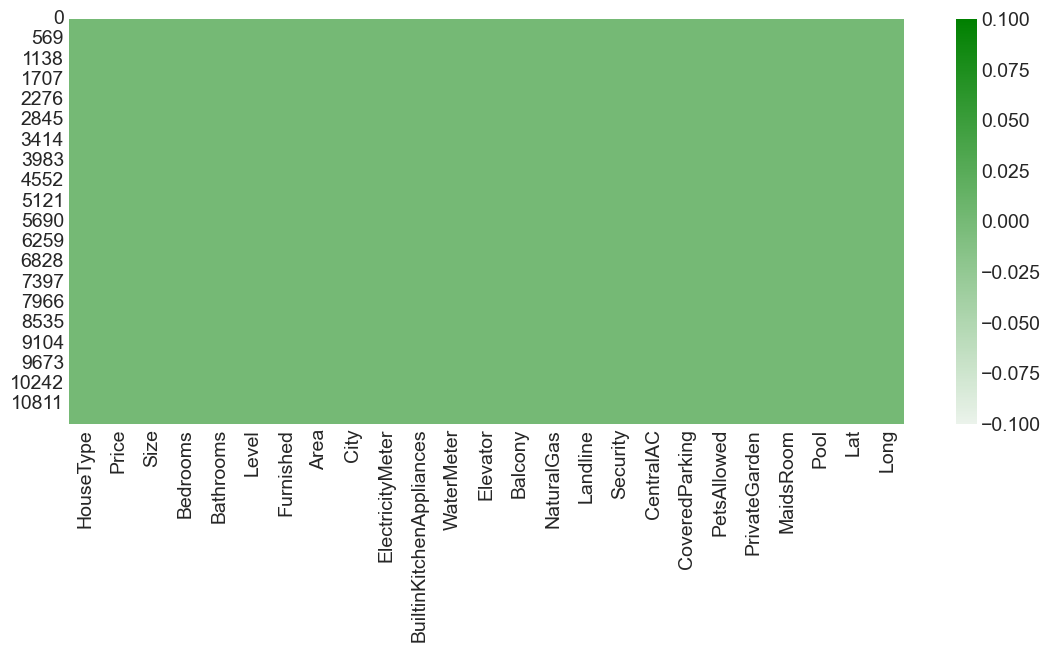

In [5]:
plt.figure(figsize=(12,5))
sns.heatmap(data.isna(), cmap=sns.light_palette("green", as_cmap=True))
plt.show()

##### Check the outliers

##### All the columns contain outliers

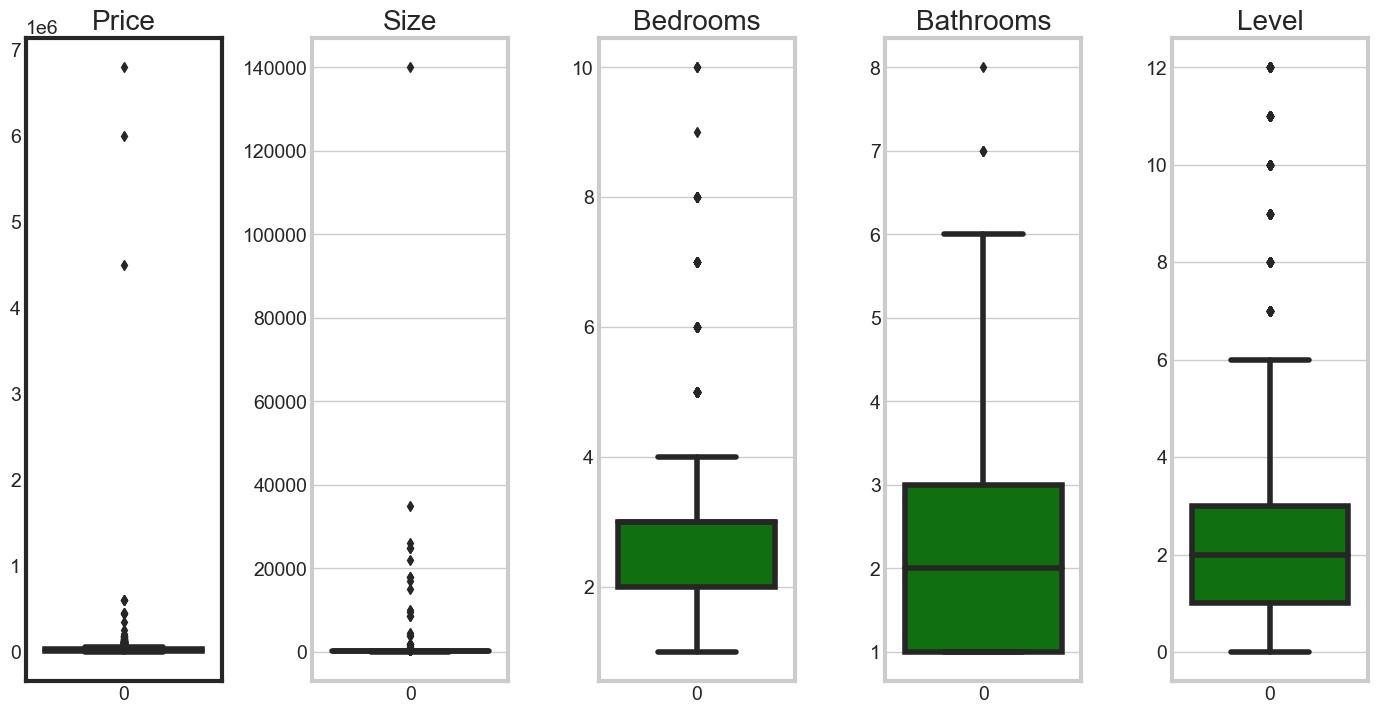

In [6]:
plt.figure(figsize=(14,14))
for i, col in enumerate(['Price', 'Size', 'Bedrooms', 'Bathrooms', 'Level']):
    plt.subplot(1+1,5,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data[col], color='green', orient='v')
    plt.title(col)
    plt.tight_layout()

In [7]:
def remove_outliers(column_name, z_threshold=2):
    """
    Remove outliers from column using the z-score method.
    """
    z_scores = zscore(data[column_name])
    outliers_mask = abs(z_scores) > z_threshold
    data_no_outliers = data[~outliers_mask]
    return data_no_outliers

In [8]:
# threshold values choosed from the .describe() table
data = remove_outliers('Price', z_threshold=0.74)
data = remove_outliers('Size',  z_threshold=0.21)

In [9]:
data.shape

(11244, 25)

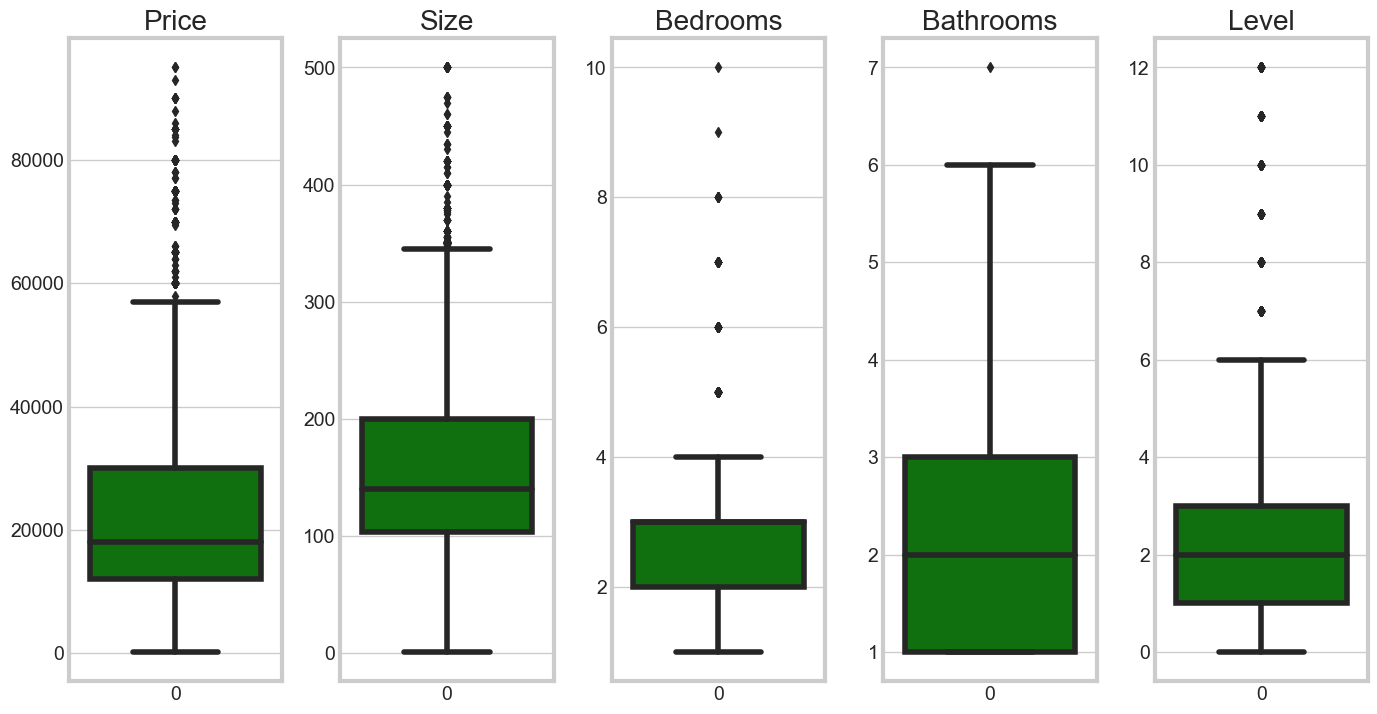

In [10]:
plt.figure(figsize=(14,14))
for i, col in enumerate(['Price', 'Size', 'Bedrooms', 'Bathrooms', 'Level']):
    plt.subplot(1+1,5,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data[col], color='green', orient='v')
    plt.title(col)
    plt.tight_layout()

##### Check distributions

##### All the columns are right skewed

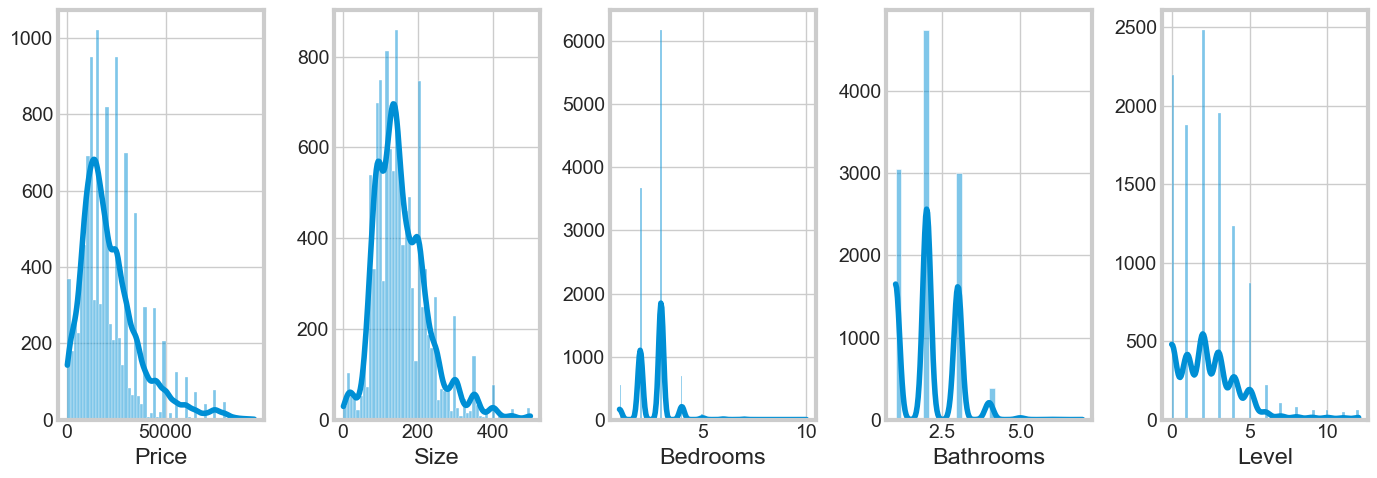

In [11]:
plt.figure(figsize=(14,5))
for i, col in enumerate(['Price', 'Size', 'Bedrooms', 'Bathrooms', 'Level']):
    plt.subplot(1,5,i+1)
    sns.histplot(data[col],kde=True)
    plt.ylabel('')
    plt.tight_layout()

## Univariate Analysis

##### Apartment is the most common house type in our dataset

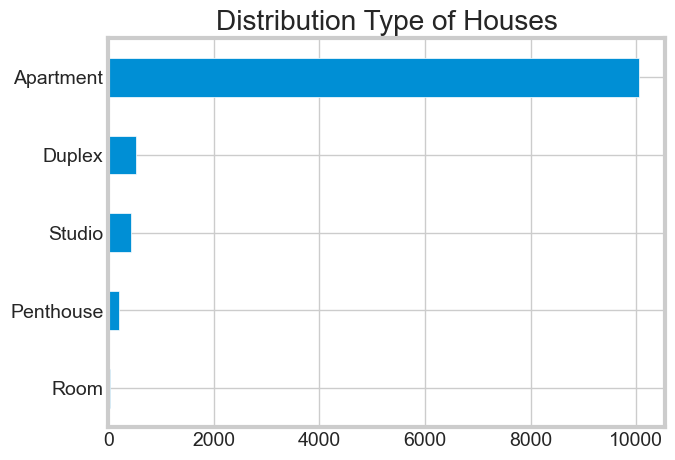

In [12]:
data['HouseType'] \
    .value_counts(ascending=True) \
    .plot(kind='barh',
          ylabel='',) 
plt.title('Distribution Type of Houses')
plt.show()

In [13]:
def px_hist_box(col, nbins=10):
    # hist plot
    hist_fig = px.histogram(data, x=col, nbins=nbins, title=f'<b> Frequency of {col} </b>')
    hist_fig.update_layout(
        plot_bgcolor = 'white'
    )
    hist_fig.update_xaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        gridcolor='lightgrey'
    )
    hist_fig.update_yaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        gridcolor='lightgrey'
    )

    # box plot
    box_fig = px.box(data, x=col, title=f'<b> Box plot for the {col} </b>')
    box_fig.update_layout(
        plot_bgcolor = 'white'
    )
    box_fig.update_xaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        gridcolor='lightgrey'
    )
    box_fig.update_yaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        gridcolor='lightgrey'
    )

    hist_fig.show()
    box_fig.show()

##### Price range from 12K to 30K EGP

In [14]:
px_hist_box('Price', 95)

##### Size range from 100 to 200 m2

In [15]:
px_hist_box('Size', 45)

##### Most common # of bedrooms 3 and 2

In [16]:
px_hist_box('Bedrooms', 20)

##### Most common # Bathrooms 2

In [17]:
px_hist_box('Bathrooms', 20)

##### Lower levels are the most common levels in the dataset

In [18]:
hist_fig = px.bar(
    data_frame=data['Level'].value_counts().sort_index(),
    title='<b> Frequency of Level (Floor No.) </b>')

hist_fig.update_layout(
    plot_bgcolor = 'white'
)
hist_fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
hist_fig.update_yaxes(
    mirror=True,
    
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

##### 52.5% of the dataset houses are Furnished
##### 1 = Furnished, 0 = Not furnished

In [19]:
px.pie(
    data,
    names='Furnished', 
    color_discrete_sequence=["black", "red"],
    title='<b> Pie Chart for Furnised Houses </b>')

In [20]:
data['Area'].value_counts(ascending=False).values[:20]

array([2493, 1353, 1012,  911,  744,  358,  254,  189,  163,  153,  149,
        145,  144,  136,  125,  124,  118,  116,  110,   92], dtype=int64)

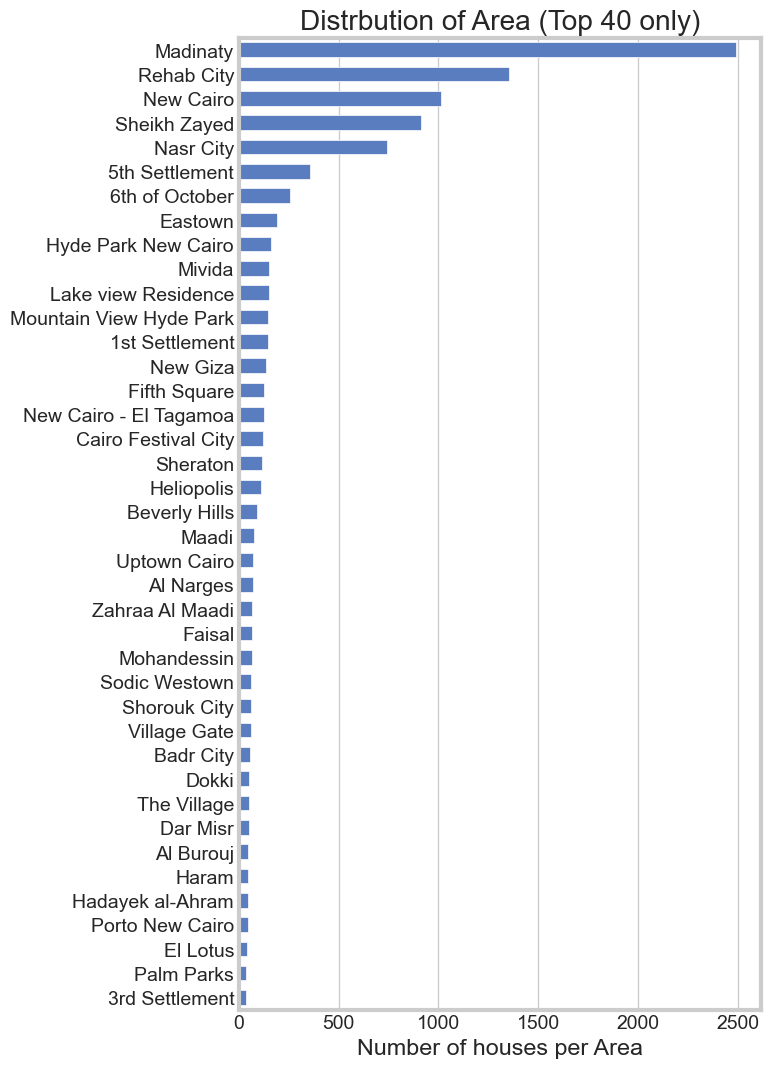

In [21]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(6,12))
sns.set_color_codes('muted')
ax = sns.barplot(
    x=data['Area'].value_counts(ascending=False).values[:40],
    y=data['Area'].value_counts(ascending=False).index[:40],
    color='b',
    width=0.6,
)
plt.xlabel('Number of houses per Area')
plt.ylabel('')
plt.title('Distrbution of Area (Top 40 only)')
plt.show()

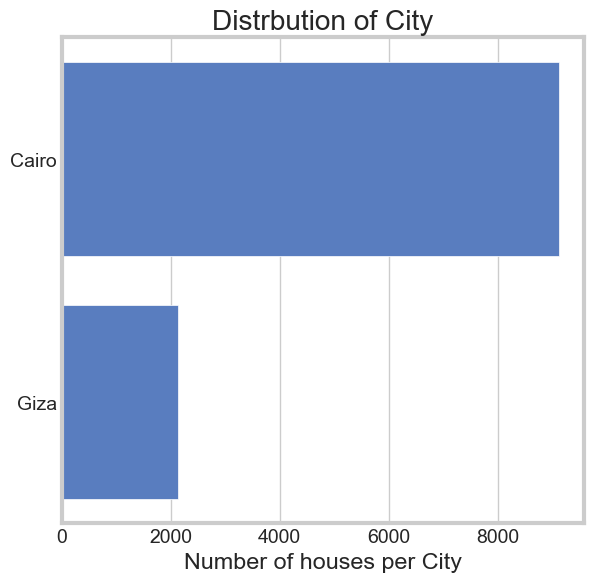

In [22]:
fig, axes = plt.subplots(figsize=(6,6))
sns.set_color_codes('muted')
ax = sns.barplot(
    x=data['City'].value_counts(ascending=False).values,
    y=data['City'].value_counts(ascending=False).index,
    color='b',
    width=0.8,
)
plt.xlabel('Number of houses per City')
plt.ylabel('')
plt.title('Distrbution of City')
plt.show()

## Correlations Heatmap: Key Observations:
- Price has +ve correlation with # of Bathrooms and almost no correlation with evelator.
- No. of Bedrooms and bathrooms has high +ve correlation with house size.
- Central AC has +ve correlation with furnished house and built-in kitchen appliances.
- Electricity meter and water meter have +ve correlation natural Gas and land line.
- Maids room has +ve correlation with Parking, pool and petsallowed.
- Level has a small +ve correlation with evelator and no correlation with the size of the house.
- Furnished as -ve correlation with # of bedrooms.

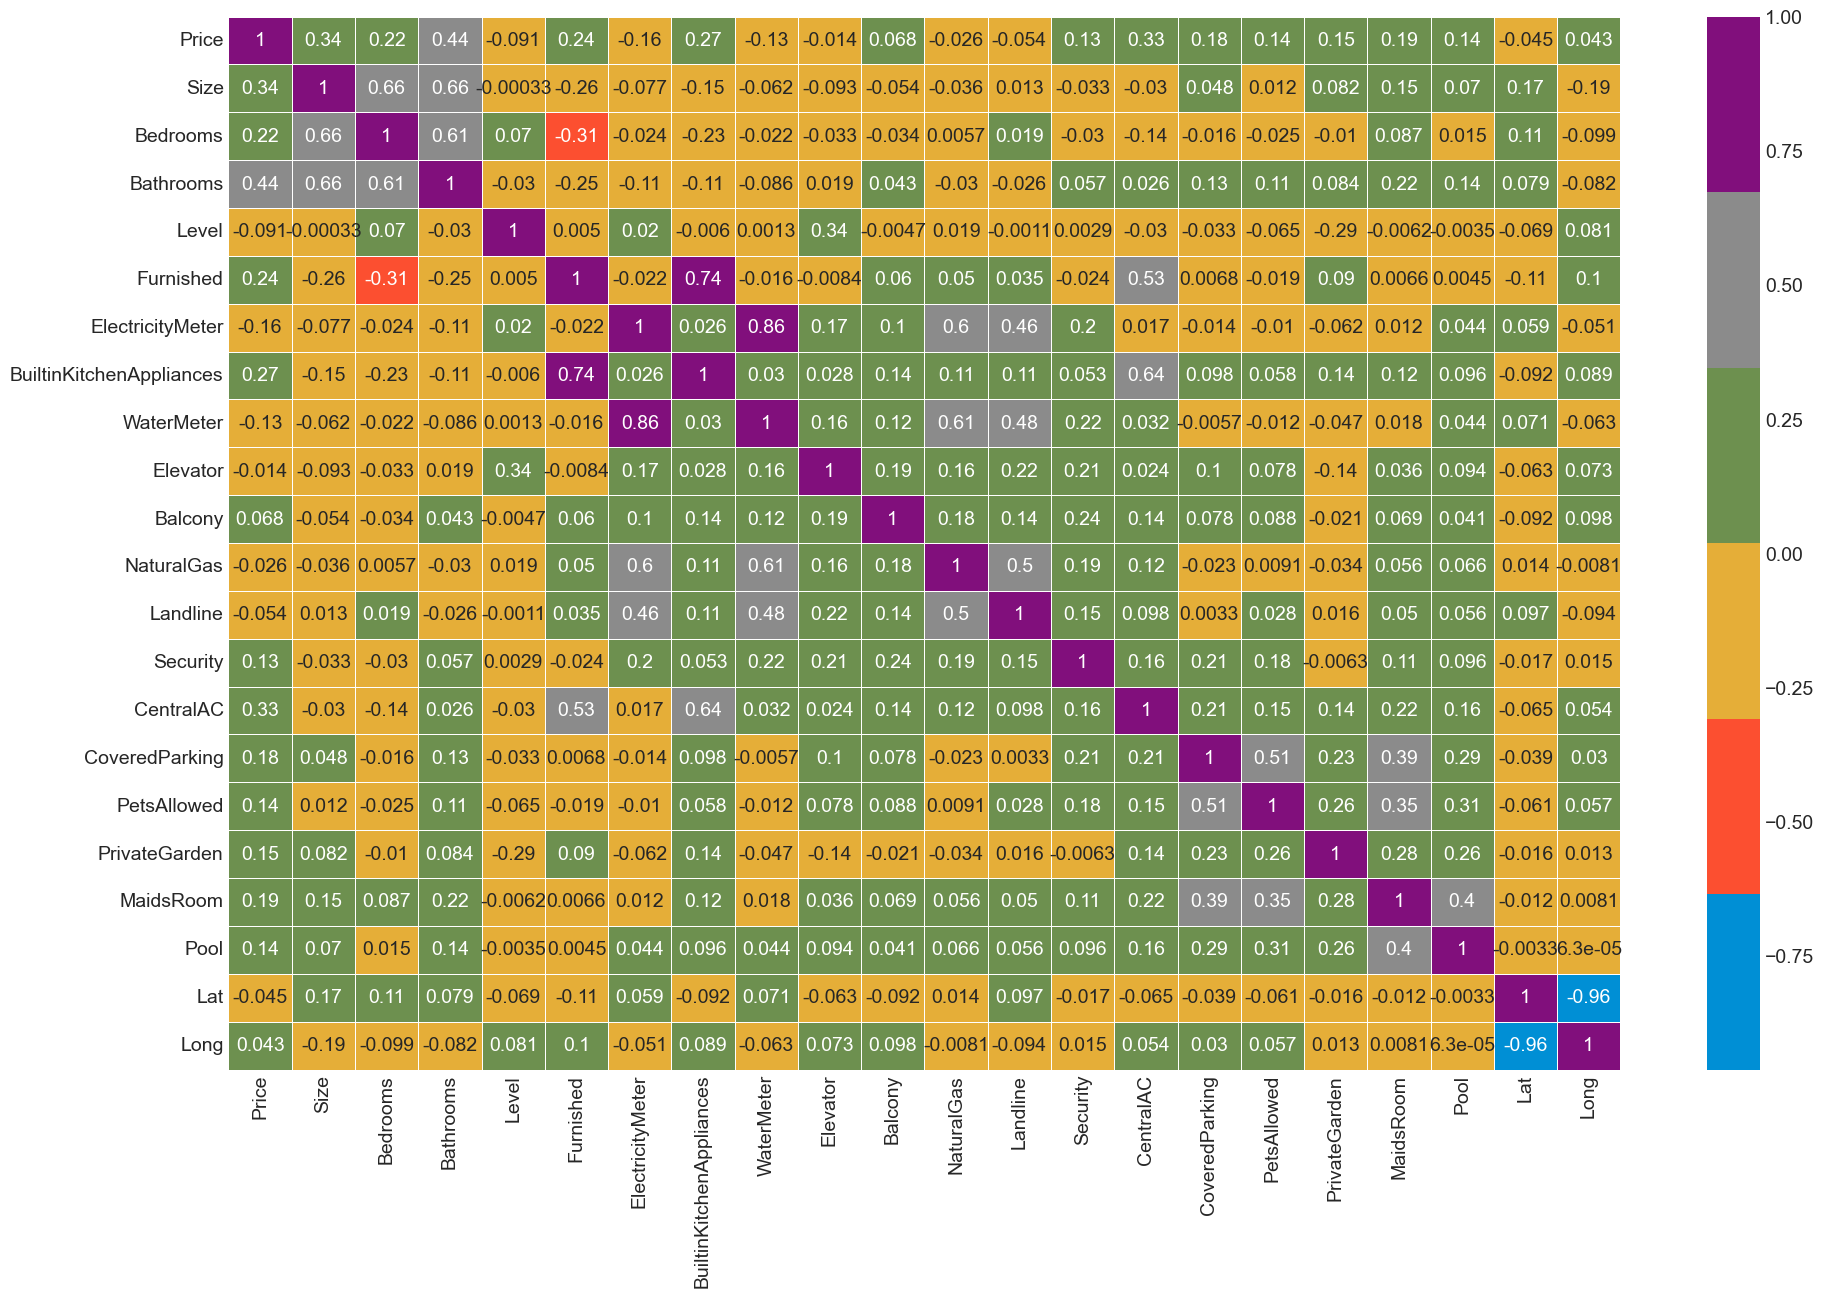

In [23]:
corr_df = data.drop(columns=['HouseType', 'Area', 'City']).corr()
plt.figure(figsize=(20,13))
sns.heatmap(corr_df, annot=True, linewidths=0.5, cmap=color_pal)
plt.show()

## Bivariate Analysis

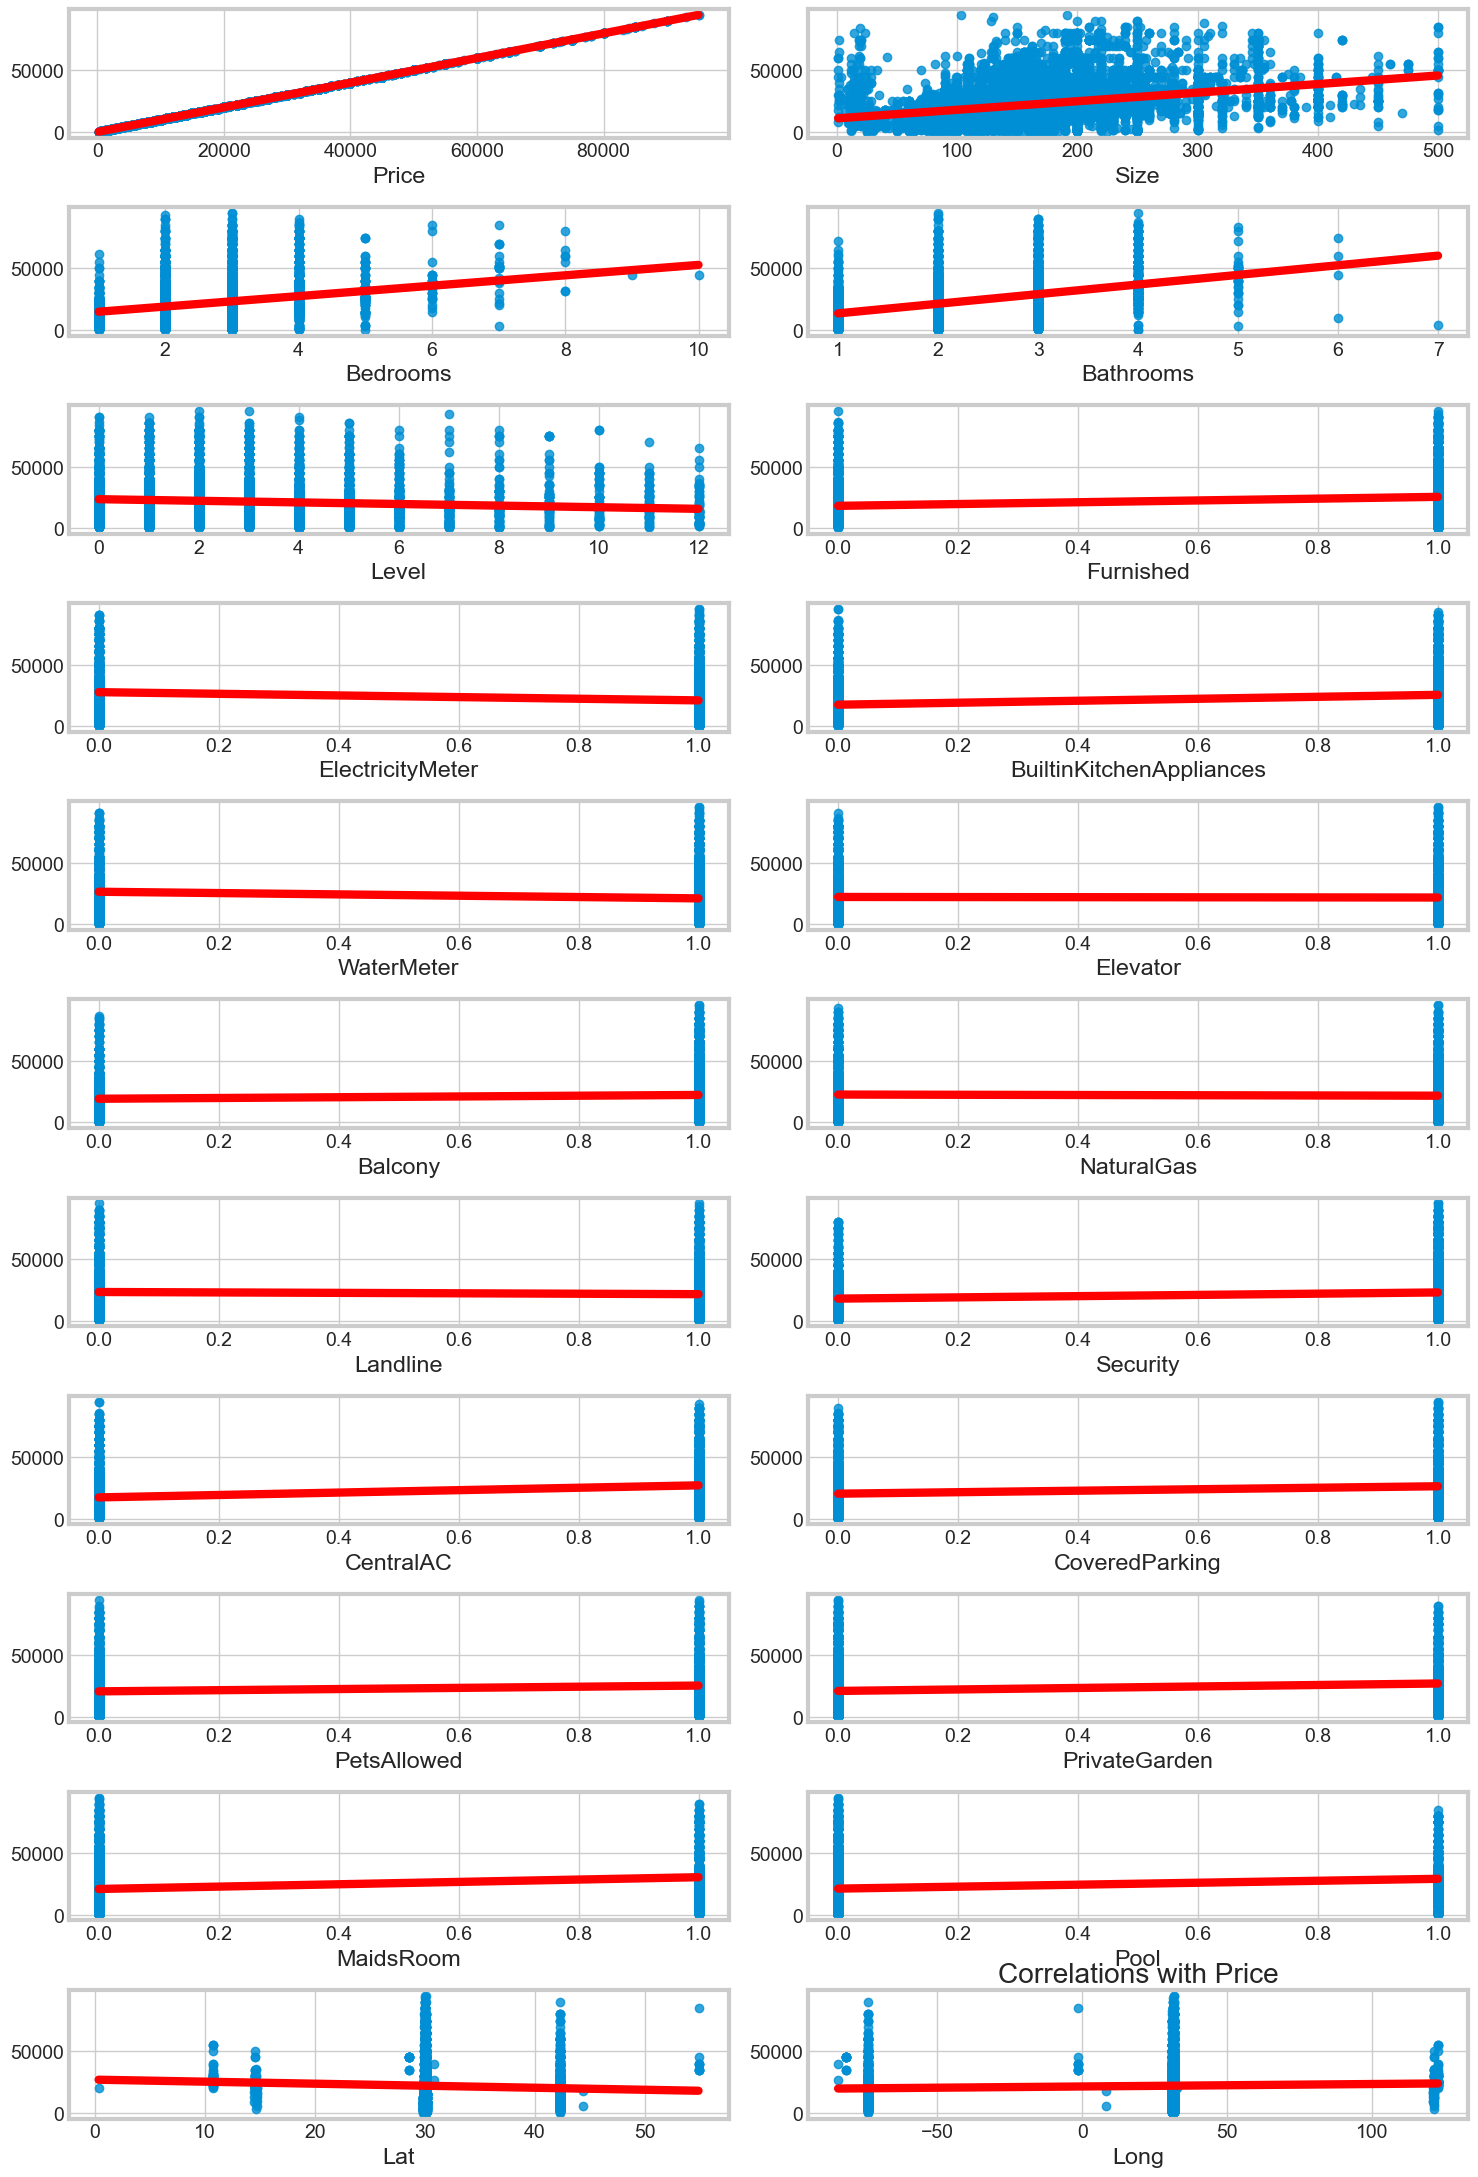

In [24]:
plt.figure(figsize=(15,22))
for i, col in enumerate(data.drop(columns=['HouseType', 'Area', 'City']).columns):
    plt.subplot(11,2,i+1)
    sns.regplot(
        data=data, 
        x=col, 
        y='Price',
        line_kws={"color": "red"})
    plt.ylabel('')
    plt.tight_layout()
plt.title('Correlations with Price')
plt.show()

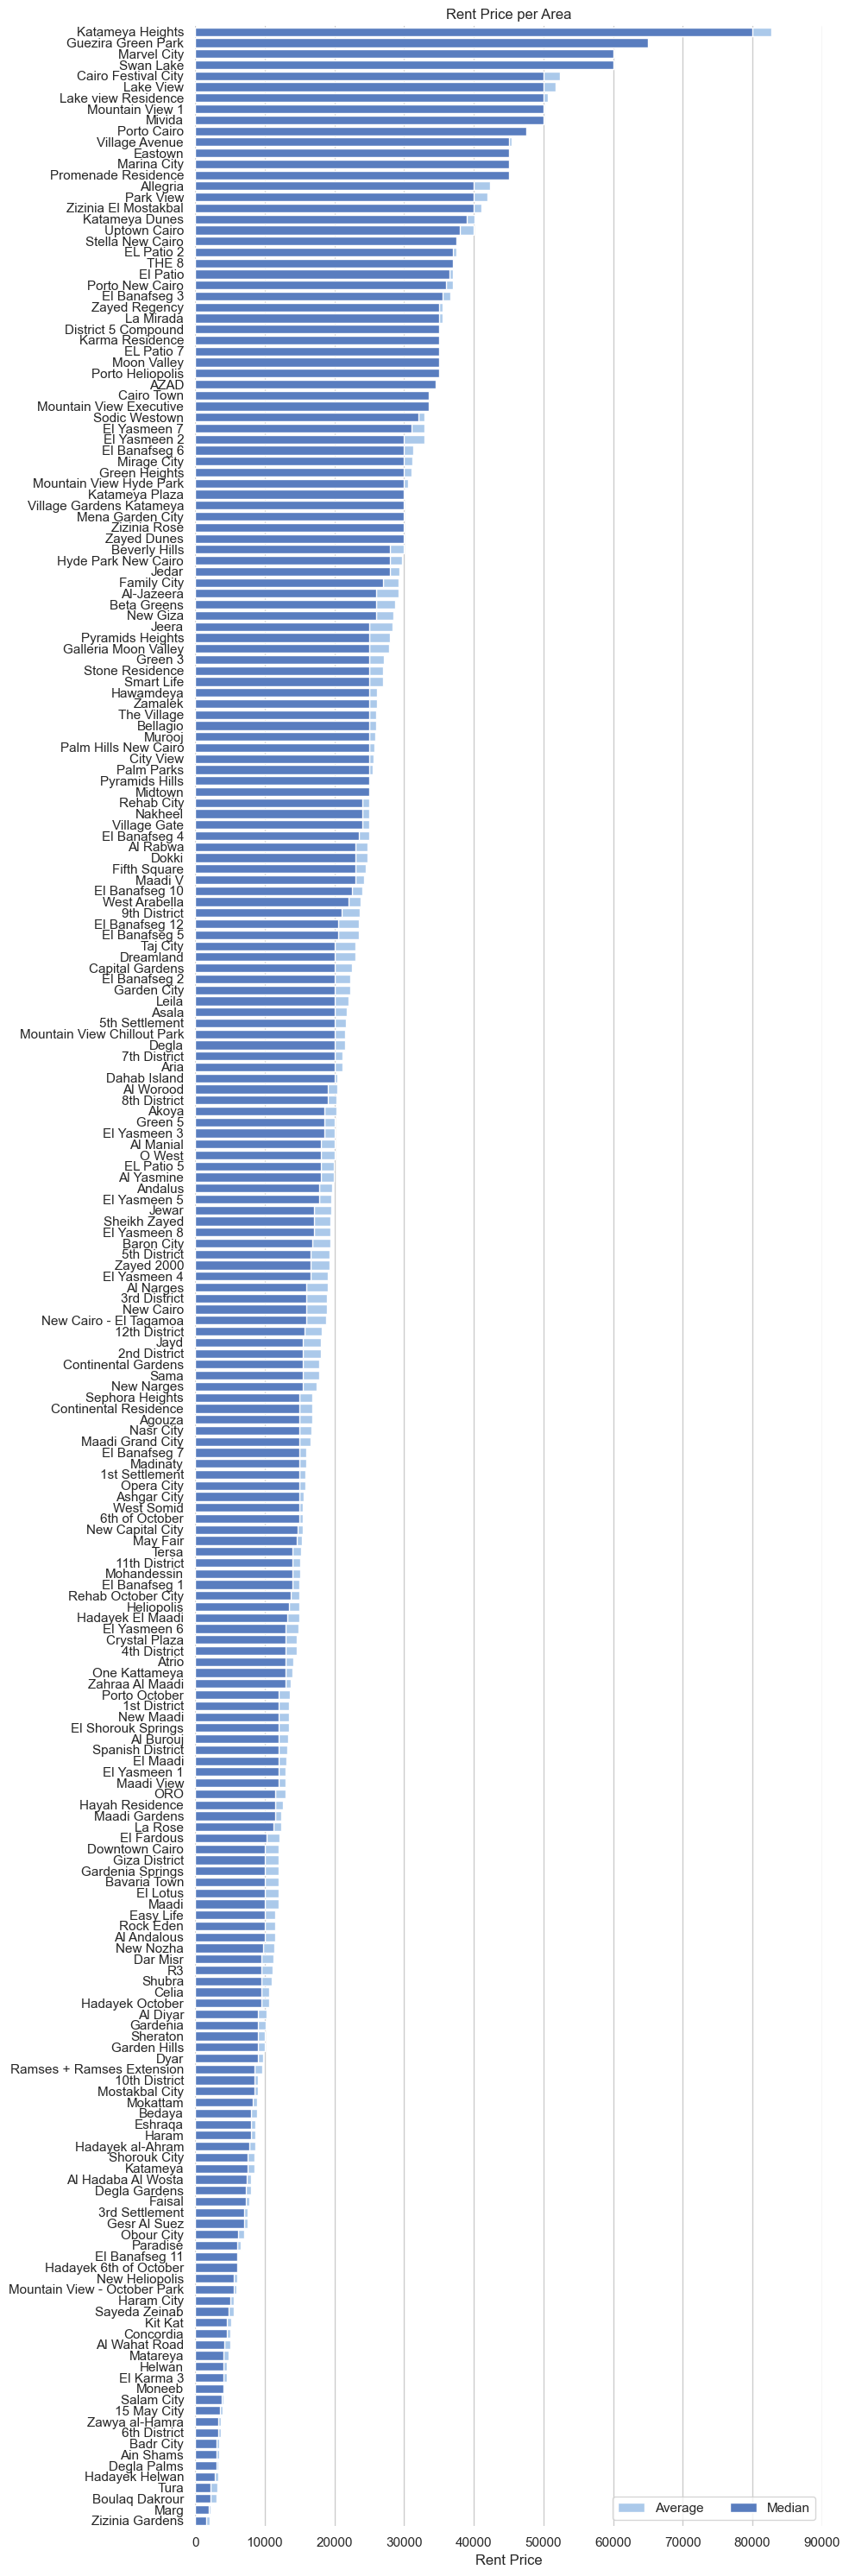

In [25]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 30))

# group & agg the dataset
mean_price = pd.DataFrame(
    data.groupby('Area')['Price'] \
    .agg('mean') \
    .sort_values(ascending=False)
    )

median_price = pd.DataFrame(
    data.groupby('Area')['Price'] \
    .agg('median') \
    .sort_values(ascending=False)
    )


# Plot the mean price
sns.set_color_codes("pastel")
sns.barplot(x=mean_price['Price'], y=mean_price.index, data=mean_price, label="Average", color="b")

# Plot the medain price
sns.set_color_codes("muted")
sns.barplot(x=median_price['Price'], y=median_price.index, data=median_price, label="Median", color="b")

# add legend & set axes
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 90_000), ylabel="", xlabel="Rent Price")
sns.despine(left=True, bottom=True)
plt.title('Rent Price per Area')
plt.tight_layout()
plt.show()

##### Prices in Cairo are higher than Giza

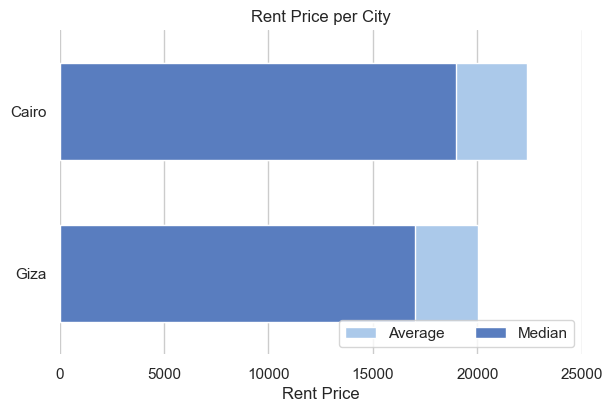

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))

# group & agg the dataset
mean_price = pd.DataFrame(
    data.groupby('City')['Price'] \
    .agg('mean') \
    .sort_values(ascending=False)
    )

median_price = pd.DataFrame(
    data.groupby('City')['Price'] \
    .agg('median') \
    .sort_values(ascending=False)
    )

# Plot the mean price
sns.set_color_codes("pastel")
sns.barplot(x=mean_price['Price'], y=mean_price.index, data=mean_price, label="Average", color="b", width=0.6)

# Plot the medain price
sns.set_color_codes("muted")
sns.barplot(x=median_price['Price'], y=median_price.index, data=median_price, label="Median", color="b", width=0.6)

# add legend & set axes
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 25_000), ylabel="", xlabel="Rent Price")
sns.despine(left=True, bottom=True)
plt.title('Rent Price per City')
plt.show()

In [27]:
data.columns

Index(['HouseType', 'Price', 'Size', 'Bedrooms', 'Bathrooms', 'Level',
       'Furnished', 'Area', 'City', 'ElectricityMeter',
       'BuiltinKitchenAppliances', 'WaterMeter', 'Elevator', 'Balcony',
       'NaturalGas', 'Landline', 'Security', 'CentralAC', 'CoveredParking',
       'PetsAllowed', 'PrivateGarden', 'MaidsRoom', 'Pool', 'Lat', 'Long'],
      dtype='object')

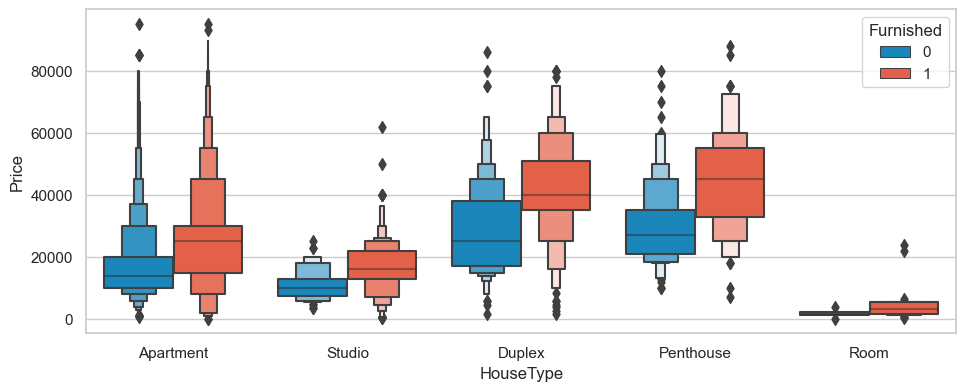

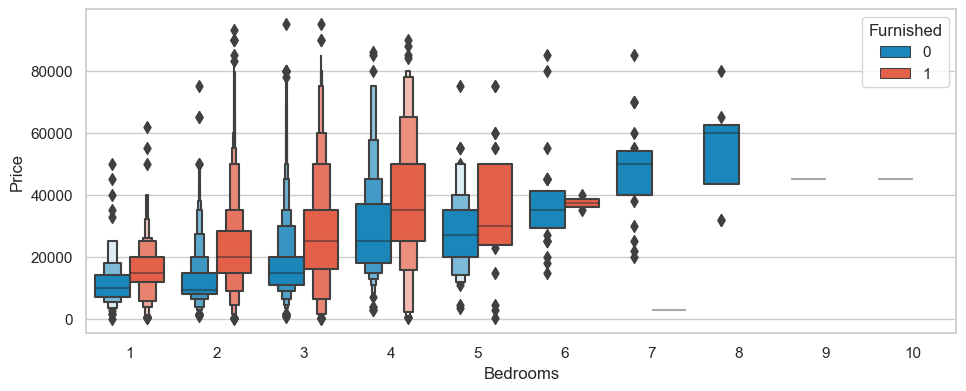

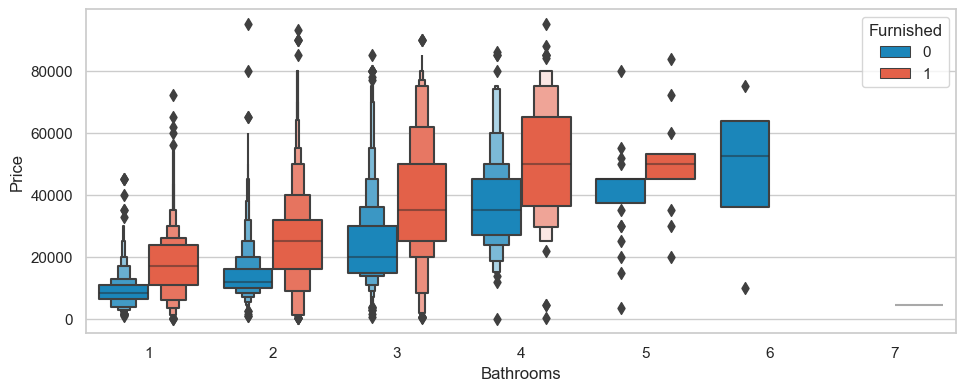

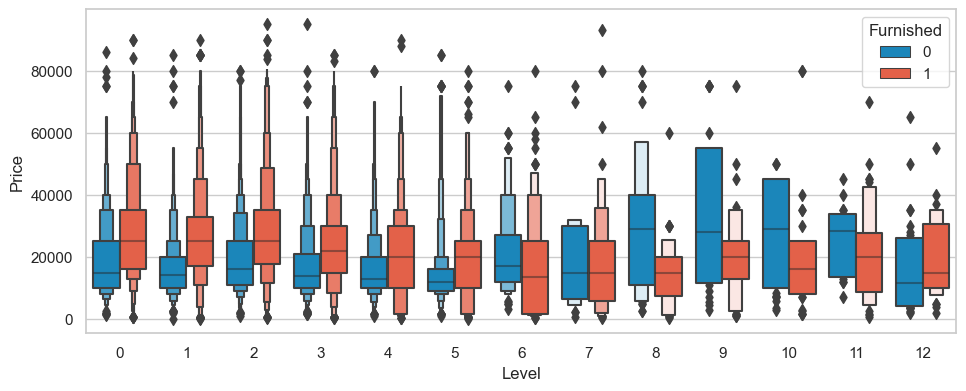

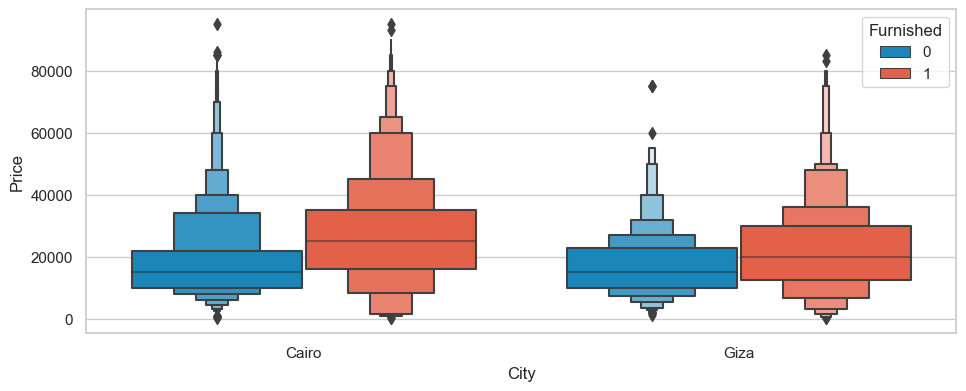

In [28]:
for col in ['HouseType', 'Bedrooms', 'Bathrooms', 'Level', 'City']:
    plt.figure(figsize=(10,4))    
    sns.boxenplot(x=col, y='Price', data=data, hue='Furnished', palette=color_pal)
    plt.show()

In [29]:
fig = px.sunburst(
    data,
    path=['City', 'Area'],
    width=900,
    height=900,
    title='<b> Areas for The 3 Biggest Cites </b> Alexandria, Cairo and Giza ',
    color_discrete_sequence=color_pal,
    )
fig.show()

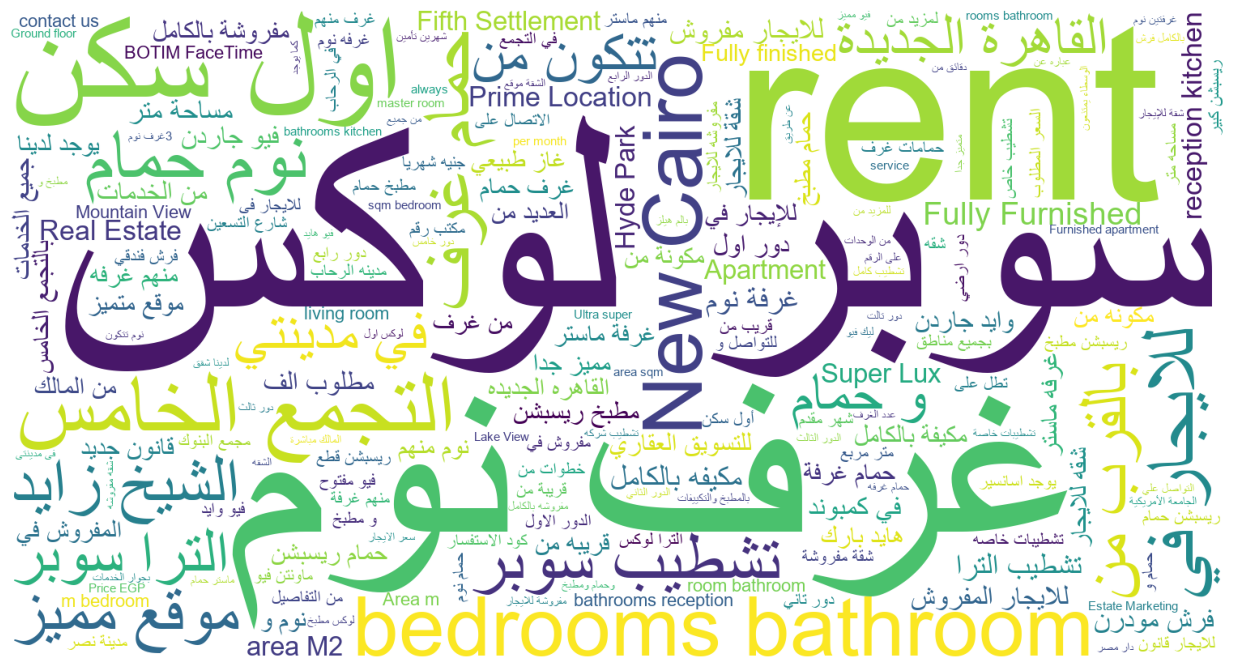

In [30]:
descriptions_file = open('../dataset/descriptions.txt', 'r', encoding='utf-8')
descriptions_file = descriptions_file.read()
text = ''.join(descriptions_file)
# https://github.com/alihoseiny/word_cloud_fa/issues/6
weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
text = weridPatterns.sub(r'', text)
text = arabic_reshaper.reshape(text)
text = get_display(text)

cloud = WordCloud(
    background_color= "white",
    font_path= 'arial.ttf',
    max_words= 200,
    width=1500,
    height=800,
    stopwords= set(STOPWORDS)
    )
cloud.generate_from_text(text)
cloud.to_file('../descriptions_word_cloud.png') 
plt.figure(figsize=(32, 8))
plt.imshow(cloud)
plt.axis('off')
plt.show()